In [77]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 

In [78]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.1)

        self.to(DEVICE)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [80]:
class Network(nn.Module):
    """CNN."""

    def __init__(self, activation_fn, zero_padding,dropout_2d, dropout):
        """CNN Builder."""
        super(Network, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=zero_padding),
#             nn.BatchNorm2d(32),
            activation_fn(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=zero_padding),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_2d),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=zero_padding),
#             nn.BatchNorm2d(128),
            activation_fn(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=zero_padding),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            activation_fn(),
            nn.Linear(1024, 512),
            activation_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(512, 10)
        )

        self.to(DEVICE)


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [81]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self, activation_fn, zero_padding,dropout_2d, dropout):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=zero_padding),
#             nn.BatchNorm2d(32, track_running_stats = False),
            activation_fn(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=zero_padding),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=zero_padding),
#             nn.BatchNorm2d(128, track_running_stats = False),
            activation_fn(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=zero_padding),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_2d),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=zero_padding),
#             nn.BatchNorm2d(256, track_running_stats = False),
            activation_fn(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=zero_padding),
            activation_fn(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(4096, 1024),
            activation_fn(),
            nn.Linear(1024, 512),
            activation_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(512, 10)
        )

        self.to(DEVICE)


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [82]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [83]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR10(root='/home/swasti/Documents/sem6/VR/Assignment3/Feature-Learning/Part_b/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/swasti/Documents/sem6/VR/Assignment3/Feature-Learning/Part_b/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset))

Files already downloaded and verified
Files already downloaded and verified
50000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


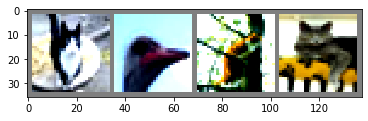

  cat  bird   cat   cat


In [84]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [85]:
activation_fn = nn.Sigmoid # nn.Sigmoid or nn.Tanh or nn.ReLU
zero_padding = 1 # 0 for no padding
batch_norm = False # False for no batch_norm
dropout_2d = 0.05
dropout = 0.1 
m = 0.9 # momentum

In [86]:
net = Network(activation_fn, zero_padding, dropout_2d, dropout)
# if(batch_norm==False):
#     net.apply(deactivate_batchnorm)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)#, momentum = m)

In [87]:
for epoch in range(2):  # loop over the dataset multiple times
    since = time.time()
    running_loss = 0.0

    net.train()

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

time_elapsed = time.time() - since 
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

[1,  2000] loss: 2.321
[1,  4000] loss: 2.315
[1,  6000] loss: 2.314
[1,  8000] loss: 2.316
[1, 10000] loss: 2.315
[1, 12000] loss: 2.314
[2,  2000] loss: 2.315
[2,  4000] loss: 2.311
[2,  6000] loss: 2.314
[2,  8000] loss: 2.312
[2, 10000] loss: 2.310
[2, 12000] loss: 2.311
Training complete in 2m 21s


In [88]:
# PATH = './cifar_CNN_sig.pth'
# torch.save(net, PATH)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


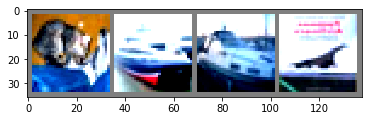

GroundTruth:    cat  ship  ship plane


In [89]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [90]:

# net = torch.load(PATH)
net.eval()

Network(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Sigmoid()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.05, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Sigmoid()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=1024, out_f

In [91]:
# outputs = net(images)

In [92]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE) 
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


In [93]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 100 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
